In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange, tqdm
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image
import os

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
im = Image.open("D:/VSCode/IntelSystem/Lab4/data/metal/train/Crazing/Cr_2.bmp")

In [6]:
im_n = np.array(im)

In [12]:
a = transform(im)

In [13]:
a.shape

torch.Size([1, 200, 200])

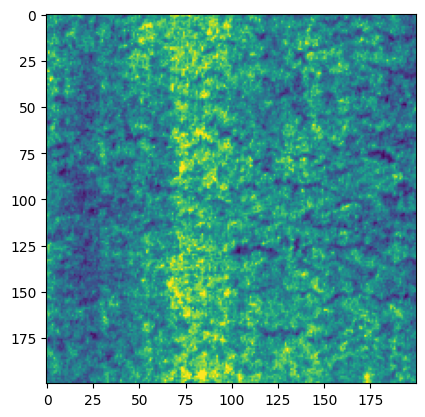

In [14]:
plt.imshow(a[0])

In [25]:
class CustomDataset(Dataset):
    def __init__(self, path: str, transform, test: bool = False):
        if(test):
            path+="/test/"
        else:
            path+="/train/"
        self.labels = list()
        self.data = list()
        i: int = 0
        for dir in os.listdir(path):
            values = [transform(Image.open(path+"/"+dir+"/"+p)) for p in os.listdir(path+"/"+dir)]
            self.data.extend(values)
            self.labels.extend([i for j in range(len(values))])
            i+=1
        self.current = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = int(self.labels[idx])
        return data, label
    
    def __iter__(self):
        self.current = 0
        return self
    
    def __next__(self):
        if self.current < self.__len__():
            self.current += 1
            return self.__getitem__(self.current-1)
        raise StopIteration

In [56]:
batch_size = 20

transform = transforms.Compose([transforms.ToTensor()])

train_data = CustomDataset("./data/metal", transform)
test_data = CustomDataset("./data/metal", transform, True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [28]:
def init_batch_generator(dataloader: torch.utils.data.DataLoader):
    """
    Возвращает функцию, вызов которой возвращает следующие batch_size
    примеров и им соответствуюющих меток из train_data, train_labels.
    
    Примеры выбираются последовательно, по кругу. Массивы с входными 
    примерами и метками классов перемешиваются в начале каждого круга.
    """
    def f():
        while True:
            for i, (images, labels) in enumerate(dataloader):
                yield images, labels
    return f()

In [31]:
conv1 = nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=7, stride=4, padding=3)
conv2 = nn.Conv2d(in_channels= 6, out_channels=12, kernel_size=3, stride=2, padding=0)
conv3 = nn.Conv2d(in_channels= 12, out_channels=24, kernel_size=3, stride=1, padding=1)
maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

In [46]:
x.shape

torch.Size([24, 3, 3])

In [45]:
x = train_data[10][0]
x = conv1(x)
x = maxpool(x)
x = conv2(x)
x = maxpool(x)
x = conv3(x)
x = maxpool(x)

In [118]:
class Classifier(nn.Module):
    def __init__(self,
                 size_in: int = 200,
                 size_out: int = 6): 
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=7, stride=4, padding=3)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels=36, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels= 36, out_channels=72, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(72*3*3, size_out)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.ReLU(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.ReLU(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.ReLU(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [127]:
net = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [135]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)

In [50]:
class Metrics:
    def __init__(self, lables, predicted):
        leble = np.arange(6)
        self.matrix = np.zeros((leble.size, leble.size))
        for i in range(leble.size):
            for j in range(leble.size):
                self.matrix[i, j]=((leble[j]==predicted)*(lables==leble[i])).sum()
    
    def accuracy(self):
        return np.array([self.matrix.diagonal().sum()/self.matrix.sum()
                         if self.matrix.diagonal().sum() != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def precision(self):
        return np.array([self.matrix[i,i]/self.matrix[i,:].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def recall(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def FPR(self):
        return np.array([(self.matrix[i,:].sum()-self.matrix[i,i])/(self.matrix[:,i].sum()+self.matrix[i,:].sum()-2*self.matrix[i,i])
                         if (self.matrix[i,:].sum()-self.matrix[i,i]) != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def TPR(self):
        return np.array([self.matrix[i,i]/self.matrix[:,i].sum()
                         if self.matrix[i,i] != 0 else 0.
                         for i in range(self.matrix.shape[0])])
    def F(self, b = 1):
        b=b**2
        return (1+b)*self.precision()*self.recall()/(b*self.precision()+self.recall())
    def all(self, b=1):
        return pd.DataFrame(np.array([self.accuracy(), self.precision(), self.recall(), self.FPR(), self.TPR(), self.F(b)]).T,
                            columns=["accuracy", "precision", "recall", "FPR", "TPR", "F"])

In [74]:
def train(net: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          num_epochs: int = 5):
    net.train()

    data_iterator = init_batch_generator(train_loader)
    test_iterator = init_batch_generator(test_loader)
    progress = trange(num_epochs*len(train_loader))
    loss_arr = list()
    loss_test_arr = list()
    accuracy_arr = list()
    accuracy_test_arr = list()

    for epoch in progress:
        net.train()
        data, labels = next(data_iterator)
        outputs = net(data)
        loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(6)] for i in range(len(labels))]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        loss_arr.append(loss.item())
        accuracy_arr.append(correct / total)

        progress.set_postfix_str(f"Loss: {loss.item() :.4f}, Accuracy: {(correct / total) * 100 :.2f}%")
        # net.eval()

        # outputs = net(data)
        # loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(10)] for i in range(len(labels))]))
        # total = labels.size(0)
        # _, predicted = torch.max(outputs.data, 1)
        # correct = (predicted == labels).sum().item()
        # loss_arr.append(loss.item())
        # accuracy_arr.append(correct / total)

        # data, labels = next(test_iterator)
        # outputs = net(data)
        # loss = criterion(outputs, torch.tensor([[ 1. if j == labels[i] else 0. for j in range(10)] for i in range(len(labels))]))
        # total = labels.size(0)
        # _, predicted = torch.max(outputs.data, 1)
        # correct = (predicted == labels).sum().item()
        # loss_test_arr.append(loss.item())
        # accuracy_test_arr.append(correct / total)

    return loss_arr, accuracy_arr, loss_test_arr, accuracy_test_arr

In [136]:
out = train(net, train_loader, criterion, optimizer, 5)

  0%|          | 0/415 [00:00<?, ?it/s]

In [137]:
labels = list()
pred = list()
for image, lable in test_data:
    _, predicted = torch.max(net(image[None,:,:,:]), 1)
    pred.extend(predicted)
    labels.append(lable)
metrics = Metrics(labels, pred)
metrics.all()

,accuracy,precision,recall,FPR,TPR,F
0,0.763889,1.000000,0.923077,0.000000,0.923077,0.960000
1,0.763889,0.833333,0.555556,0.200000,0.555556,0.666667
2,0.763889,0.916667,1.000000,1.000000,1.000000,0.956522
3,0.763889,0.416667,0.714286,0.777778,0.714286,0.526316
4,0.763889,0.916667,0.733333,0.200000,0.733333,0.814815
5,0.763889,0.500000,0.750000,0.750000,0.750000,0.600000
